#### 서울 대기질 LSTM

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
# data 
data = pd.read_csv('./dataset/seoul_pm10.csv', encoding='cp949')

In [3]:
# 날짜 변환
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
# 결측치 처리
data['pm10'] = data['pm10'].fillna(data['pm10'].mean())
data['pm2.5'] = data['pm2.5'].fillna(data['pm2.5'].mean())

In [4]:
# 지역 원-핫 인코딩
data = pd.get_dummies(data, columns=['area'], prefix='area')

In [5]:
data.head()

,pm10,pm2.5,area_강남구,area_강동구,area_강북구,area_강서구,area_관악구,area_광진구,area_구로구,area_금천구,...,area_성북구,area_송파구,area_양천구,area_영등포구,area_용산구,area_은평구,area_종로구,area_중구,area_중랑구,area_평균
date,,,,,,,,,,,,,,,,,,,,,
2022-12-31 23:00:00,57.0,44.0,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2022-12-31 23:00:00,68.0,55.0,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2022-12-31 23:00:00,59.0,42.0,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2022-12-31 23:00:00,62.0,40.0,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2022-12-31 23:00:00,57.0,38.0,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [6]:
# preprocessing
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data[['pm10']])

In [7]:
# LSTM 모델에 적합한 데이터셋 생성 함수
def create_dataset(dataset, time_step=12):
    X, y =[], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:i + time_step])
        y.append(dataset[i + time_step])
    return np.array(X), np.array(y)

In [8]:
# 데이터셋 분리 (학습 데이터와 테스트 데이터)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [9]:
time_step = 12  # 12개월 단위로 예측
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [10]:
# LSTM 모델 생성
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

c:\AI_project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32, verbose=1)

Epoch 1/5
5694/5694 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - loss: 2.7199e-04 - val_loss: 2.6436e-04
Epoch 2/5
5694/5694 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - loss: 2.3061e-04 - val_loss: 2.6336e-04
Epoch 3/5
5694/5694 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - loss: 2.1901e-04 - val_loss: 2.8423e-04
Epoch 4/5
5694/5694 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 2.1491e-04 - val_loss: 2.7147e-04
Epoch 5/5
5694/5694 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - loss: 2.2294e-04 - val_loss: 2.6229e-04


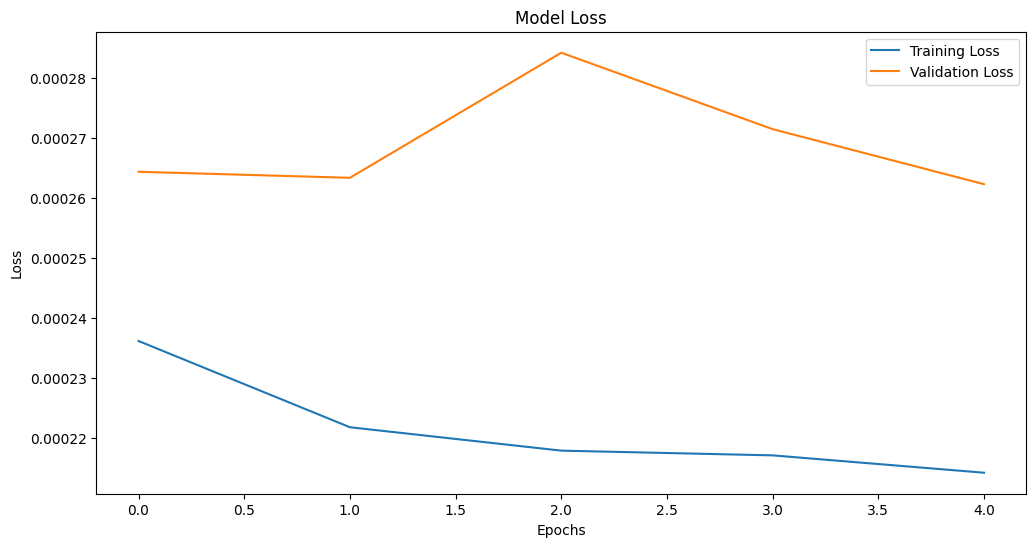

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# 테스트 데이터 예측
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

5694/5694 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


In [15]:
# 예측값 역정규화
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

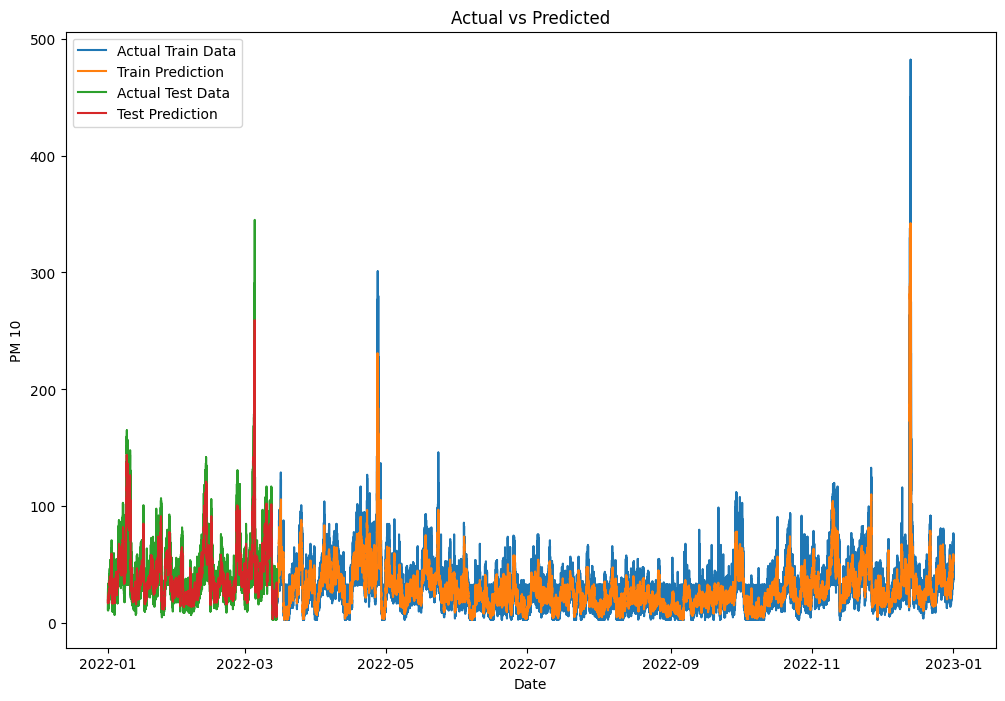

In [16]:
# 예측 결과 시각화
plt.figure(figsize=(12, 8))
plt.plot(data.index[:len(y_train)], y_train, label='Actual Train Data')
plt.plot(data.index[time_step:len(train_predict) + time_step], train_predict, label='Train Prediction')
plt.plot(data.index[len(train_data):len(train_data) + len(test_predict)], y_test, label='Actual Test Data')
plt.plot(data.index[len(train_data):len(train_data) + len(test_predict)], test_predict, label='Test Prediction')
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('PM 10')
plt.legend()
plt.show()